In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import uuid
from scipy.stats import lognorm, mode

In [285]:
# HELPER FUNCTIONS


def calculate_relative_value(df, verbose=False):
    position_mean = df['FANTASYPTS'].mean()
    position_stddev = np.std(df['FANTASYPTS'])

    for index, row in df.iterrows():
        df.loc[index, 'relative_value'] = ((df.loc[index, 'FANTASYPTS'] - position_mean)/position_stddev) + 1 # +1 transformation on the end of this zscore calculation is to reduce the number of negative values - this is important because later the relative values will be adjusted, and I want the distribution of zscores to be preserved, but also to lie mostly above 0
        if verbose:
            print(f"Index: {index}, RK: {row['RK']}, Pts: {row['FANTASYPTS']}, Position: {row['position']}, Mean: {position_mean}, Stddev: {position_stddev}, Zscore: {df.loc[index, 'relative_value']}")
    return(df)

def relative_value_adjustment(df, adjustment, verbose=False):
    # adjust the relative values so that QBS, WRS, and RBS are emphasized in the beginning rounds and kickers and defenses are taken as late as possible
    # adjustment should be list of len(nunique(position)) - we have 6 positions, so should be length 6

    if verbose:
        print(f'QB adjustment: {adjustment[0]}\nWR adjustment: {adjustment[1]}\nRB adjustment: {adjustment[2]}\nTE adjustment: {adjustment[3]}\nK adjustment: {adjustment[4]}\nDST adjustment: {adjustment[5]}\n')
    
    
    # make relative value adjustments by position
    df.loc[df['position'] == 'QB', 'relative_value'] = (df.loc[df['position'] == 'QB', 'relative_value'] * adjustment[0])
    df.loc[df['position'] == 'WR', 'relative_value'] = (df.loc[df['position'] == 'WR', 'relative_value'] * adjustment[1])
    df.loc[df['position'] == 'RB', 'relative_value'] = (df.loc[df['position'] == 'RB', 'relative_value'] * adjustment[2])
    df.loc[df['position'] == 'TE', 'relative_value'] = (df.loc[df['position'] == 'TE', 'relative_value'] * adjustment[3])
    df.loc[df['position'] == 'K', 'relative_value'] = (df.loc[df['position'] == 'K', 'relative_value'] * adjustment[4])
    df.loc[df['position'] == 'DST', 'relative_value'] = (df.loc[df['position'] == 'DST', 'relative_value'] * adjustment[5])

    # remove relative values < 1
    df['relative_value'] = df['relative_value'].clip(lower=1)

    return(df)


def impute_and_smooth(df, verbose=False):
    # need to impute some incorrect values

    # FANTASYPTS is the number of fantasy points a player scored last season (2024), so rookies have 0. Also players who were injured
    # suffer, for example CMC has only 40.3 points. 


    # here I am imputing 0 values (rookies) based on the average of the 4 closest ranked players

    for index, row in df.iterrows():

        # get closest_4 values 
        if index == 0:
            closest_4 = [1, 2, 3, 4]
        elif index == 1:
            closest_4 = [0, 2, 3, 4]
        elif index == (len(df['RK']) - 1):
            closest_4 = [index-4, index-3, index-2, index-1]
        elif index == (len(df['RK']) - 2):
            closest_4 = [index-4, index-3, index-2, index]
        else:
            closest_4 = [index+1, index+2, index-1, index-2]

        if row['FANTASYPTS'] == 0:
            knearest = (df.loc[closest_4[0], 'FANTASYPTS'] + df.loc[closest_4[1], 'FANTASYPTS'] + 
                        df.loc[closest_4[2], 'FANTASYPTS'] + df.loc[closest_4[3], 'FANTASYPTS'])/4
            df["FANTASYPTS"] = df["FANTASYPTS"].astype(float) # get rid of warning - not sure when FANTASYPTS is not a float but this fixes
            df.loc[index, "FANTASYPTS"] = round(knearest, 1)

    # I want to smooth the curve and minimize outliers to fix things like CMC pts score. Therefore I will calculate the average of the 4
    # closest players and if the player in question is > 1.5 standard devations away from the mean of those players, I will set their
    # FANTASYPTS score to the mean of those 4 players. This has to be done before merging the positions because it will be easier to handle
    # the beginning and end of the lists. One caveat to this is that I do not want to mimimize high outliers, just low outliers.

    for index, row in df.iterrows():

        # get closest_4 values 
        if index == 0:
            closest_4 = [1, 2, 3, 4]
        elif index == 1:
            closest_4 = [0, 2, 3, 4]
        elif index == (len(df['RK']) - 1):
            closest_4 = [index-4, index-3, index-2, index-1]
        elif index == (len(df['RK']) - 2):
            closest_4 = [index-4, index-3, index-2, index]
        else:
            closest_4 = [index+1, index+2, index-1, index-2]
        
        # calculate mean, stddev, zscore
        mean = round((df.loc[closest_4[0], 'FANTASYPTS'] + df.loc[closest_4[1], 'FANTASYPTS'] + 
                df.loc[closest_4[2], 'FANTASYPTS'] + df.loc[closest_4[3], 'FANTASYPTS'])/4, 1)
        std_dev = round((((df.loc[closest_4[0], 'FANTASYPTS'] - mean)**2 + (df.loc[closest_4[1], 'FANTASYPTS'] - mean)**2 +
                (df.loc[closest_4[2], 'FANTASYPTS'] - mean)**2 + (df.loc[closest_4[3], 'FANTASYPTS'] - mean)**2)/3)**0.5, 2)
        zscore = round((df.loc[index, 'FANTASYPTS'] - mean)/std_dev, 2)

        if verbose:
            print(f"Index: {index}, RK: {row['RK']}, Pts: {row['FANTASYPTS']}, Position: {row['position']}, Mean of 4 closest: {mean}, Stddev: {std_dev}, Zscore: {zscore}")

        if zscore < -2.4:
            if verbose:
                print(f'Need to replace rank {row["RK"]} points ({row["FANTASYPTS"]}) with mean: {mean}')
            df["FANTASYPTS"] = df["FANTASYPTS"].astype(float) # get rid of warning - not sure when FANTASYPTS is not a float but this fixes
            df.loc[index, "FANTASYPTS"] = mean
    
    # I also want to get rid of negative FANTASYPTS values, because they are annoying

    df.loc[df['FANTASYPTS'] < 0, 'FANTASYPTS'] = 0
        

    return df

def pick_player(players, team, num_players_allowed):
    max_num_players_allowed = len(players)-1#define max for recursive search
    if num_players_allowed > max_num_players_allowed:
        num_players_allowed = max_num_players_allowed

    pick_selection = True

    while pick_selection:   # make sure that a pick is valid before modifying teams
        if num_players_allowed > max_num_players_allowed:
            num_players_allowed = max_num_players_allowed
        pick = random.randint(0,num_players_allowed-1)

        options = players.iloc[0:num_players_allowed]

        if team.starting_positions_needed.size != 0:
            if options.iloc[pick]['position'] in team.starting_positions_needed:
                pick_selection = False
            else:
                num_players_allowed += 1
        elif team.bench_positions_needed.size != 0:
            if options.iloc[pick]['position'] in team.bench_positions_needed:
                pick_selection = False
            else:
                num_players_allowed += 1
        elif team.bench_positions_needed.size == 0 and team.starting_positions_needed.size == 0:
            pick_selection = False
    
    if team.starting_positions_needed.size != 0: # if there are starting positions left
        if options.iloc[pick]['position'] in team.starting_positions_needed: # if the pick has a position in starting_positions
            team.add_drafted_player(options.iloc[pick]) # add player
            team.add_points(options.iloc[pick]['proj_points']) # add score
            team.remove_starting_position_needed(options.iloc[pick]['position']) # remove option from starting_positions
            team.add_points_added(options.iloc[pick])
            players.drop(pick, axis='index', inplace=True) # remove picked player from the draft pool
            return players, team
        else:
            pass
    elif team.bench_positions_needed.size != 0: # if there are bench positions left
        if options.iloc[pick]['position'] in team.bench_positions_needed: # if the pick has a position in bench_positions
            team.add_drafted_player(options.iloc[pick]) # add player
            team.add_points(options.iloc[pick]['proj_points'] * 0.2) # add score * 0.2 - this is a bench position, so their total value should be smaller compared to starting players
                                                                    # this can be modulated to give bench players more of an impact
                                                                    # Also affects kickers and defense, but because I don't want them to account for
                                                                    # much in the simulation, that is fine.
            team.add_points_added(options.iloc[pick])
            team.remove_bench_position_needed(options.iloc[pick]['position']) # remove option from bench_positions
            players.drop(pick, axis='index', inplace=True) # remove picked player from the draft pool
            return players, team
        else:
            pass
    elif team.bench_positions_needed.size == 0 and team.starting_positions_needed.size == 0: # if there are no bench or starting positions then return
        return players, team
    
    return players, team # return if no conditions are met

def run_monte_carlo(player_dataset, n_trials=10000000):  # 10 million default trials

    new_dataset = pd.DataFrame()

    for trial in range(n_trials):
        if (trial % 100000) == 0:
            print(f"{(trial/n_trials)*100}% complete...")
        trial_dataset = player_dataset.copy()
        
        draft = Draft()
        trial_dataset = draft.initialize_proj_points(trial_dataset)
        draft.run_draft(trial_dataset)

        for team in draft.league.teams:
            new_row = pd.DataFrame([{'team_id': uuid.uuid4(), 'sim_id': trial, 'draft_position': team.draft_pos, 'proj_total_points': team.season_points_total, 
                                     'proj_position': team.league_position, 'positions': team.position_picked_list, 
                                     'players': team.player_picked_list, 'player_points_added': team.player_points_added}])
            new_dataset = pd.concat([new_dataset, new_row], ignore_index=True)
    
    return new_dataset

def draw_player_distribution_graph(player_indexes, players_adjusted):

    for i in player_indexes:
        sigma = players_adjusted.loc[i, 'sigma']    # Shape parameter
        mu = 4         # Mean of the underlying normal distribution
        n_samples = 1000
        C = 44 + 14 * (1/players_adjusted.loc[i, 'relative_value'])

        name = players_adjusted.loc[i, 'name']

        # Create distribution object
        dist = lognorm(s=sigma, scale=np.exp(mu))

        # sample distribution
        pre_transformation = dist.rvs(size=n_samples)
        samples = -(pre_transformation) + C + players_adjusted.loc[i, 'FANTASYPTS']

        #plot sample distribution
        sns.histplot(samples, bins=50, stat='density', kde=False, alpha=0.6, label='Samples', legend=True)

        # Plot the PDF
        x = np.linspace(min(pre_transformation), max(pre_transformation), 1000)
        new_x = -x + C + players_adjusted.loc[i, 'FANTASYPTS']
        pdf = dist.pdf(x)
        pdf_dict = {'x': new_x, 'pdf': pdf}

        sns.lineplot(data=pdf_dict, x='x', y='pdf', color='red', label='PDF')
        title_string = name + " Log-Normal Points Distribution"
        plt.title(title_string)
        plt.xlabel("Projected Points")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(False)
        plt.show()

        stats_string = name + " Distribution Statistics"
        print(stats_string)
        print(f"Mean: {round(samples.mean(), 2)}")
        print(f"Median: {round(np.median(samples), 2)}")
        print(f"Standard deviation: {round(samples.std(), 2)}")
        print(f"Maximum: {round(max(samples), 2)}")
        print(f"Minimum: {round(min(samples), 2)}")
        print(f"2024 Fantasy Points: {players_adjusted.loc[i, 'FANTASYPTS']}")



In [284]:
#CLASS DEFINITIONS

class Team:
    def __init__(self):
        self.starting_positions_needed = np.array(['QB', 'WR', 'WR', 'RB', 'RB', 'TE']) #list of positions needed to draft full team - will remove items from list as team grows
        self.bench_positions_needed = np.array(['QB', 'WR', 'WR', 'RB', 'RB', 'K', 'DST']) #list of positions needed to draft full team - will remove items from list as team grows

        self.draft_pos = 0 # integer - 1 <= draft_pos <= number of teams in draft

        self.season_points_total = 0 # sum of total projected points for the season - running tally as draft goes on
        self.league_position = 0 # final league position - integer between 1 and number of teams (inclusive)

        self.position_picked_list = np.array([])     # 1 = QB, 2 = WR, 3 = RB, 4 = TE, 5 = K, 6 = DEF 
        self.player_picked_list = np.array([])
        self.player_points_added = np.array([])
    
    #add points to season_points_total - will use to calculate league position - add points after every player drafted
    def add_points(self, points):
        self.season_points_total += points
    
    # remove position from starting_positions_needed - will need to keep track of what to draft
    def remove_starting_position_needed(self, pos):
        
        matches = self.starting_positions_needed == pos

        #gets index if if finds match, gets -1 otherwise
        if np.any(matches):
            index = int(np.where(matches)[0][0])
        else:
            index = -1

        self.starting_positions_needed = np.delete(self.starting_positions_needed, index)

    # remove position from bench_positions_needed - will need to keep track of what to draft
    def remove_bench_position_needed(self, pos):
        
        matches = self.bench_positions_needed == pos

        #gets index if if finds match, gets -1 otherwise
        if np.any(matches):
            index = int(np.where(matches)[0][0])
        else:
            index = -1

        self.bench_positions_needed = np.delete(self.bench_positions_needed, index)

    # set the league position based on season_points_total
    def set_league_position(self, pos):
        self.league_position = pos

    # set draft position
    def set_draft_position(self, pos):
        self.draft_pos = pos
    
    # add player position to draft list
    def add_drafted_player(self, player):
        self.position_picked_list = np.append(self.position_picked_list, player['position'])
        self.player_picked_list = np.append(self.player_picked_list, player['name'])

    def add_points_added(self, player):
        self.player_points_added = np.append(self.player_points_added, player['proj_points'])


class League:
    def __init__(self, num_teams='10team'):
        self.num_teams = num_teams

        if num_teams == '12team': # generate 12 team league
            team1 = Team()
            team2 = Team()
            team3 = Team()
            team4 = Team()
            team5 = Team()
            team6 = Team()
            team7 = Team()
            team8 = Team()
            team9 = Team()
            team10 = Team()
            team11 = Team()
            team12 = Team()
            self.teams = [team1, team2, team3, team4, team5, team6, team7, team8, team9, team10, team11, team12]
        else: #generate 10 team league
            team1 = Team()
            team2 = Team()
            team3 = Team()
            team4 = Team()
            team5 = Team()
            team6 = Team()
            team7 = Team()
            team8 = Team()
            team9 = Team()
            team10 = Team()            
            self.teams = [team1, team2, team3, team4, team5, team6, team7, team8, team9, team10]

    def initialize_draft_positions(self):
        num_teams = len(self.teams) # get number of teams in draft
        draft_order = list(range(1, num_teams+1)) # set list of draft order
        random.shuffle(draft_order) # shuffle list of draft order
        for i in range(num_teams):
            self.teams[i].set_draft_position(draft_order[i]) #sequentially set draft order
        self.teams.sort(key=lambda x: x.draft_pos, reverse=False) # sort teams by draft positions
    
    def set_league_positions(self):
        self.teams.sort(key=lambda x: x.season_points_total, reverse=False) # sort teams by points
        for i in range(len(self.teams)):
            self.teams[i].league_position = i + 1


class Draft: # class for drafting teams
    def __init__(self, num_teams='10team'):
        self.rounds = 13
        self.league = League(num_teams)
        self.league.initialize_draft_positions()

    def run_draft(self, players): # run draft based on passed in player dataset
        for i in range(self.rounds):
            for team in self.league.teams:  
                result = pick_player(players, team, 5)
                players = result[0].reset_index(drop=True)
        self.league.set_league_positions()
    
    def print_teams(self): # print the teams created from the draft
        for team in self.league.teams:
            print(f"Players picked: {team.player_picked_list}")
            print(f"Positions picked: {team.position_picked_list}")
    
    def initialize_proj_points(self, players): #initialize proj_points by sampling from a players pdf
        
        # sample using: s = -(dist.rvs(size=1))+C+player['FANTASYPTS'] - this will pull one sample from the distribution
        # C = 44 + 14(1/relative_value)  - this will get the mode to around 0 then increase mean for the worst players more than the best

        for i, r in players.iterrows():
            C = 44 + 14 * (1/r['relative_value'])
            dist = r['proj_dist']
            pts = r['FANTASYPTS']
            sample = dist.rvs(size=1).item()  
            x = -sample + C + pts
            players.loc[i, 'proj_points'] = x
            #print(f"index: {i}, proj_points: {players.loc[i, 'proj_points']}, id: {r['id']} actual points: {r['FANTASYPTS']}")
        return(players)

In [278]:
# Dataset creation
# Source: https://www.fantasypros.com/nfl/rankings/half-point-ppr-cheatsheets.php


# have to merge all positions together because the original dataset didn't have position :/
qbs = pd.read_csv('FantasyPros_2025_Draft_QB_Rankings.csv')
qbs['position'] = 'QB'
qbs = qbs[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]


wrs = pd.read_csv('FantasyPros_2025_Draft_WR_Rankings.csv')
wrs['position'] = 'WR'
wrs = wrs[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]


rbs = pd.read_csv('FantasyPros_2025_Draft_RB_Rankings.csv')
rbs['position'] = 'RB'
rbs = rbs[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]


tes = pd.read_csv('FantasyPros_2025_Draft_TE_Rankings.csv')
tes['position'] = 'TE'
tes = tes[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]


ks = pd.read_csv('FantasyPros_2025_Draft_K_Rankings.csv')
ks['position'] = 'K'
ks = ks[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]


dst = pd.read_csv('FantasyPros_2025_Draft_DST_Rankings.csv')
dst['position'] = 'DST'
dst = dst[['RK', 'FANTASYPTS', 'position', 'PLAYER NAME']]

# impute and smooth the distribution
qbs_smoothed = impute_and_smooth(qbs, verbose=False)
wrs_smoothed = impute_and_smooth(wrs, verbose=False)
rbs_smoothed = impute_and_smooth(rbs, verbose=False)
tes_smoothed = impute_and_smooth(tes, verbose=False)
ks_smoothed = impute_and_smooth(ks, verbose=False)
dst_smoothed = impute_and_smooth(dst, verbose=False)

#calculate relative values based on smoothed distribution
qbs_rv = calculate_relative_value(qbs_smoothed, verbose=False)
wrs_rv = calculate_relative_value(wrs_smoothed, verbose=False)
rbs_rv = calculate_relative_value(rbs_smoothed, verbose=False)
tes_rv = calculate_relative_value(tes_smoothed, verbose=False)
ks_rv = calculate_relative_value(ks_smoothed, verbose=False)
dst_rv = calculate_relative_value(dst_smoothed, verbose=False)

players = pd.concat([qbs_rv, wrs_rv, rbs_rv, tes_rv, ks_rv, dst_rv]).reset_index(drop=True)
players['RK'] = players['RK'].astype(str) # change type of RK to string


# define importance of each position - (QB, WR, RB, TE, K, DST)
position_importance = [0.9, 1, 1, 0.72, 0.2, 0.2] # QB = 0.9, WR = 1, RB = 1, TE = 0.72, K = 0.2, DST = 0.2


players_adjusted = relative_value_adjustment(players, position_importance, verbose=False)
players_adjusted['id'] = players_adjusted['position'].str.cat(players_adjusted['RK'], sep='')

players_adjusted = players_adjusted.sort_values(by='relative_value', ascending=False).reset_index(drop=True)

players_adjusted = players_adjusted.drop(['RK'], axis=1) # drop rank

#reformat player names
for i, r in players_adjusted.iterrows():
    players_adjusted.loc[i, 'name_lower'] = players_adjusted.loc[i, 'PLAYER NAME'].lower()
    players_adjusted.loc[i, 'name'] = players_adjusted.loc[i, 'name_lower'].replace(" ", "-")

players_adjusted = players_adjusted.drop(['PLAYER NAME'], axis=1) # drop temp name columns
players_adjusted = players_adjusted.drop(['name_lower'], axis=1) # drop temp name columns


#create sigma value for lognormal distribution creation - this value will be based on relative_value
#use min-max normalization
#first scale to [0, 1)
minmax = (players_adjusted['relative_value'] - min(players_adjusted['relative_value']))/(max(players_adjusted['relative_value']) - min(players_adjusted['relative_value']))

# then adjust ranges
players_adjusted['sigma'] = 0.1 + minmax * (0.4-0.1)


# every player needs a pdf of the lognormal function - need to add the distribution to the dataset so that we can sample
# from the pdf for every draft

# key notes - sigma can vary over the interval (0.1, 0.4) - the closer to 0, the less skew there is - I want there to be more skew
# the higher a players relative value - regression to the mean dictates that an extreme event (that players season) will likely be
# followed by a less extreme event - key here is "likely"

# mu should stay constant at 4

mu = 4   # Mean of the underlying normal distribution

# Create distribution object for each player
for i, r in players_adjusted.iterrows():
    players_adjusted.loc[i, 'proj_dist'] = lognorm(s=r['sigma'], scale=np.exp(mu))
players_adjusted['proj_points'] = 0


#players_adjusted.to_csv('player_data_all.csv') # save player data as a csv for distribution analysis

players_adjusted.head(10)

,FANTASYPTS,position,relative_value,id,name,sigma,proj_dist,proj_points
0,339.5,WR,4.897355,WR1,ja'marr-chase,0.400000,<scipy.stats._distn_infrastructure.rv_continuo...,0
1,338.8,RB,4.006102,RB3,saquon-barkley,0.331396,<scipy.stats._distn_infrastructure.rv_continuo...,0
2,336.9,RB,3.983493,RB2,jahmyr-gibbs,0.329655,<scipy.stats._distn_infrastructure.rv_continuo...,0
3,326.9,RB,3.864503,RB6,derrick-henry,0.320496,<scipy.stats._distn_infrastructure.rv_continuo...,0
4,266.0,WR,3.787193,WR2,justin-jefferson,0.314545,<scipy.stats._distn_infrastructure.rv_continuo...,0
5,311.2,RB,3.677687,RB1,bijan-robinson,0.306116,<scipy.stats._distn_infrastructure.rv_continuo...,0
6,258.7,WR,3.676932,WR7,amon-ra-st.-brown,0.306058,<scipy.stats._distn_infrastructure.rv_continuo...,0
7,311.1,RB,3.676497,RB4,christian-mccaffrey,0.306024,<scipy.stats._distn_infrastructure.rv_continuo...,0
8,240.5,WR,3.402035,WR8,brian-thomas-jr.,0.284897,<scipy.stats._distn_infrastructure.rv_continuo...,0
9,230.8,WR,3.255524,WR9,drake-london,0.273620,<scipy.stats._distn_infrastructure.rv_continuo...,0


In [281]:
players = players_adjusted.copy()

draft_data = run_monte_carlo(players, n_trials=1) # run simulation! 10 million times :)
print("\nSimulation complete.\n")

print(draft_data.info())

#draft_data.to_csv('draft_data.csv') # save draft data as a csv

0.0% complete...

Simulation complete.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   team_id              10 non-null     object 
 1   sim_id               10 non-null     int64  
 2   draft_position       10 non-null     int64  
 3   proj_total_points    10 non-null     float64
 4   proj_position        10 non-null     int64  
 5   positions            10 non-null     object 
 6   players              10 non-null     object 
 7   player_points_added  10 non-null     object 
dtypes: float64(1), int64(3), object(4)
memory usage: 772.0+ bytes
None


/var/folders/9x/j_x_jtsx3351d7dmn0r9ms000000gn/T/ipykernel_74885/781112842.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '358.65954119902455' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  players.loc[i, 'proj_points'] = x


<h1>Appendix 1:</h1>

<h2>Visualizations</h2>

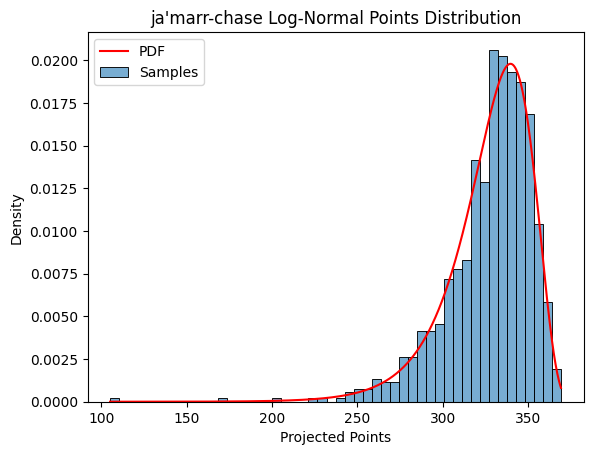

ja'marr-chase Distribution Statistics
Mean: 327.25
Median: 332.2
Standard deviation: 25.62
Maximum: 369.43
Minimum: 105.04
2024 Fantasy Points: 339.5


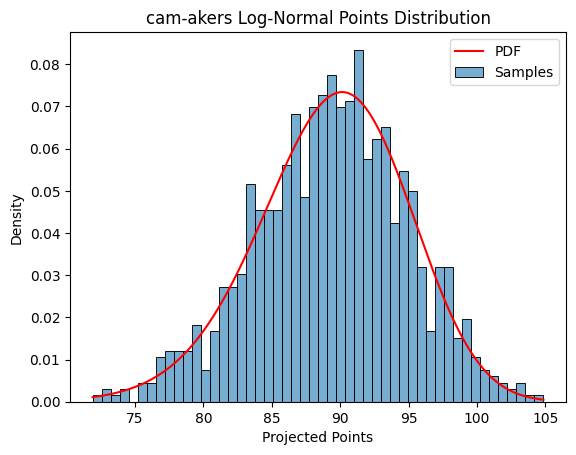

cam-akers Distribution Statistics
Mean: 89.38
Median: 89.59
Standard deviation: 5.56
Maximum: 104.86
Minimum: 71.9
2024 Fantasy Points: 86.2


In [286]:
draw_player_distribution_graph([0,220], players_adjusted)